In [60]:
%matplotlib inline
import random
import numpy as np
import tensorflow as tf
from laplace.curvature import KFAC
from laplace.sampler import Sampler
from laplace.bnn import BNN
from experiments.dataset import F3
from experiments import plots

# tf-laplace demo

In [61]:
NUM_EPOCHS = 1000 # number of training epochs
TAU = 10          # Hyperparameter tau
N = 100           # Hyperparameter N
MC_SAMPLES = 50   # Number of Monte Carlo Samples
NUM_CLASSES = 2   # Number of classes in the multi-label-classification example
RANDOM_SEED = 666 # Random seed value

Seed random number generators

In [62]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

1. create training dataset

In [63]:
ds = F3.create(50, -5.5, 5.5)
training_set = tf.data.Dataset.from_tensor_slices(ds.get()).batch(32)
test_set = tf.data.Dataset.from_tensor_slices(ds.get_test_set(2000)).batch(256)

2. build and train model

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_dim=2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dense(NUM_CLASSES)
])
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])
model.fit(training_set, epochs=1000, verbose=True)

Epoch 1/1000
2/2 [==============================] - 0s 2ms/step - loss: 8.1537 - accuracy: 0.6400
Epoch 2/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.9359 - accuracy: 0.6400
Epoch 3/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.7214 - accuracy: 0.6400
Epoch 4/1000
2/2 [==============================] - 0s 3ms/step - loss: 7.5100 - accuracy: 0.6400
Epoch 5/1000
2/2 [==============================] - 0s 3ms/step - loss: 7.3015 - accuracy: 0.6400
Epoch 6/1000
2/2 [==============================] - 0s 3ms/step - loss: 7.0959 - accuracy: 0.6400

3. approximate curvature and create Bayesian neural network

In [65]:
kfac = KFAC.compute(model, training_set, criterion)
sampler = Sampler.create(kfac, norm=TAU, scale=N)
bnn = BNN(model, sampler)

Batch 1 done. Took 0.007913351058959961 seconds
Batch 2 done. Took 0.0060939788818359375 seconds


4. evaluate bnn on test set

In [66]:
true_labels = tf.zeros([0, NUM_CLASSES], dtype=tf.int64)
points = tf.zeros((0, 2), dtype=tf.float32)
predictions = np.zeros([MC_SAMPLES, 0, NUM_CLASSES], dtype=np.float32)
for i, (x, y) in enumerate(test_set):
    posterior_mean = model.get_weights()
    true_labels = tf.concat([true_labels, tf.cast(y, tf.int64)], axis=0)
    points = tf.concat([points, tf.cast(x, dtype=tf.float32)], axis=0)
    batch_predictions = np.zeros([MC_SAMPLES, x.shape[0], NUM_CLASSES], dtype=np.float32)
    for sample in range(MC_SAMPLES):
        sampler.sample_and_replace_weights()
        batch_predictions[sample] = tf.sigmoid(model.predict(x)).numpy()
        model.set_weights(posterior_mean)
    predictions = np.concatenate([predictions, batch_predictions], axis=1)
    print(f"Evaluated batch {i+1}/{len(test_set)}")

Evaluated batch 1/4
Evaluated batch 2/4
Evaluated batch 3/4
Evaluated batch 4/4


5. visualise uncertainty as predictive standard deviation

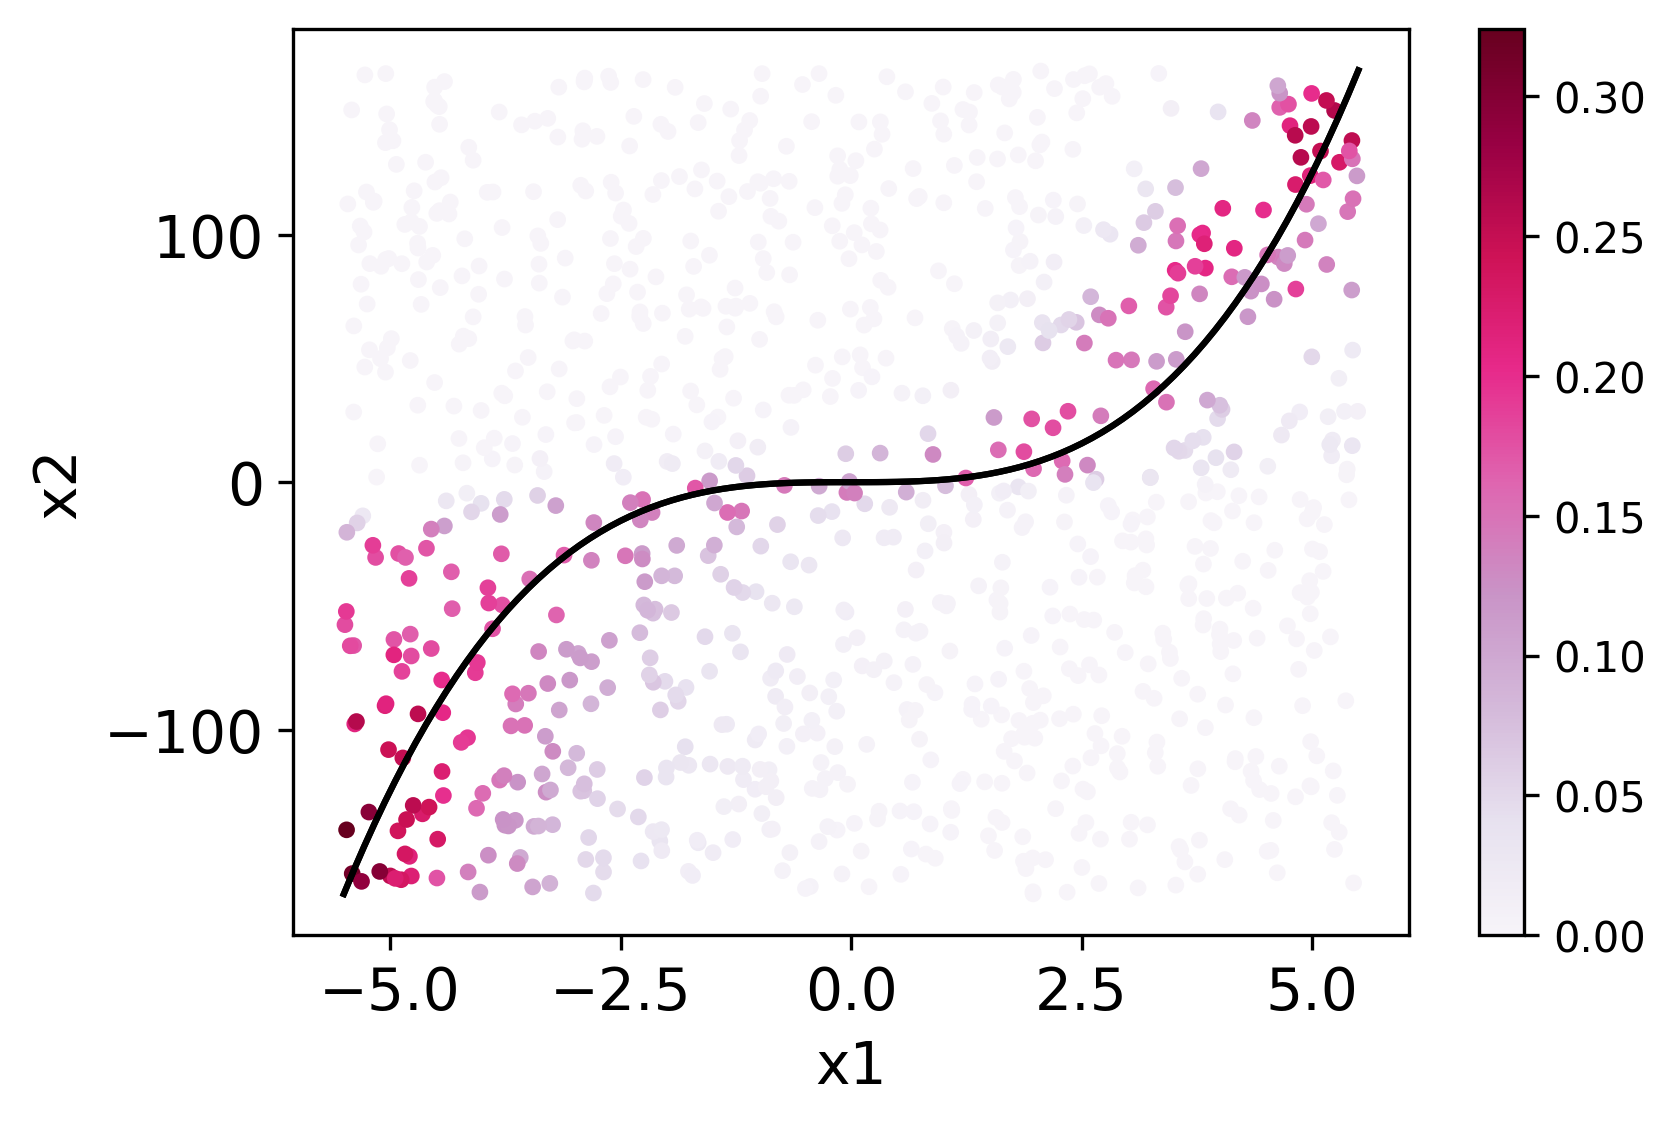

In [67]:
plotter = plots.DatasetPlotter(ds)
heatmap = plotter.plot_heatmap(points,
                               predictions.std(axis=0).sum(axis=1),
                               title=f"predictive standard deviation")
